---
title: "Calculate MI curve for uniprot SPI tree"

author: Benjamin Doran

date: today

---
## Setup

In [17]:
using DrWatson
@quickactivate "Doran_etal_2022"

using Muon
using SPI
using CSV, DataFrames
using NewickTreeTools
using CategoricalArrays: categorical
using Random: shuffle
using StatsBase
using Distances
using Glob
using StatsPlots

include(srcdir("MIcurve_functions.jl"))

collectMI_across_treedepth (generic function with 1 method)

In [ ]:
mdir = datadir("exp_pro", "UP7047", "SPItreeMIcurves") |> mkpath

"/Users/ben/projects/Doran_etal_2022/data/exp_pro/UP7047/SPItreeMIcurves"

In [ ]:
pdir = plotsdir("UniProt_MIcurves") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/UniProt_MIcurves"

In [4]:
taxaranklabels = [:Phylum, :Class, :Order, :Family, :Genus, :Species]
NCUTS = 100
NBOOT = 50

50

In [9]:
# uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"))
upobs = CSV.read(datadir("exp_raw", "UP7047", "UProwmeta.csv"), DataFrame);
rowmeta = upobs[:, [:Kingdom, :Phylum, :Class, :Order, :Family, :Genus, :Species]];
rowmeta[!, "random"] .= sample(["0", "1"], nrow(rowmeta))
rowmeta = coalesce.(rowmeta, "")
IDS = upobs.proteomeID
# close(uniprot.file)

## Caclulate MI curves for SPI tree ##
spi_tree = readnw(open(readline, projectdir("_research", "runSPIonUP7047rows", "2020_02_UP7047-supporttree.nw")));


In [10]:
havelabels = vec(mapslices(r->all(r .!= ""), Matrix(rowmeta), dims=2));

In [11]:
mean(havelabels)

0.870015609479211

In [13]:
spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_tree)

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_upgma_df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiupgma_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
spiMI_upgma_df[!, :MI_boot_mean] = vec(mean(spiupgma_bootstrappedMIs, dims=2))
spiMI_upgma_df[!, :MI_boot_std] = vec(std(spiupgma_bootstrappedMIs, dims=2));
spiMI_upgma__bootstraps_df = DataFrame(spiupgma_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(spiupgma_bootstrappedMIs, 2)]);
SPIupgma_pltdf = hcat(spiMI_upgma_df, spiMI_upgma__bootstraps_df);
boot_SPIupgma_pltdf = SPIupgma_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:10]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/MIcurve_of_uniprottree_with_bootstrap.ipynb:3


 81.770004 seconds (746.52 M allocations: 55.950 GiB, 9.36% gc time, 1.64% compilation time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/MIcurve_of_uniprottree_with_bootstrap.ipynb:6


392.509788 seconds (16.64 M allocations: 240.605 GiB, 3.21% gc time, 1.38% compilation time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/MIcurve_of_uniprottree_with_bootstrap.ipynb:9


27806.967948 seconds (9.44 M allocations: 17.346 TiB, 3.46% gc time, 0.00% compilation time: 4% of which was recompilation)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/MIcurve_of_uniprottree_with_bootstrap.ipynb:15


  4.773195 seconds (13.95 M allocations: 772.647 MiB, 2.60% gc time, 99.85% compilation time: 12% of which was recompilation)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,Kingdom,NaN,NaN
2,Kingdom,NaN,NaN
3,Kingdom,NaN,NaN
4,Kingdom,NaN,NaN
5,Kingdom,NaN,NaN
6,Kingdom,NaN,NaN
7,Kingdom,NaN,NaN
8,Kingdom,NaN,NaN
9,Kingdom,NaN,NaN


In [14]:
CSV.write(joinpath(mdir, "spi_upgma_MI.csv"), spiMI_upgma_df)
CSV.write(joinpath(mdir, "spi_upgma_MI_bootstraps.csv"), SPIupgma_pltdf)
CSV.write(joinpath(mdir, "spi_upgma_MI_bootstraps_aggregated.csv"), boot_SPIupgma_pltdf)

"/Users/ben/projects/Doran_etal_2022/data/exp_pro/UP7047/SPItreeMIcurves/spi_upgma_MI_bootstraps_aggregated.csv"

In [42]:
taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus" "species" "random"]
taxarankcolors = [:darkred :red :pink :orange :lightblue :green :aqua :grey];
# taxonomylevels = ["Phylum" "Class" "Order" "Family" "Genus" "Species" "random"]
# taxarankcolors = [:red :pink :orange :lightblue :green :aqua :grey];
# taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus"  "random"]
# taxarankcolors = [:darkred :red :pink :orange :lightblue :green  :grey];

1×8 Matrix{Symbol}:
 :darkred  :red  :pink  :orange  :lightblue  :green  :aqua  :grey

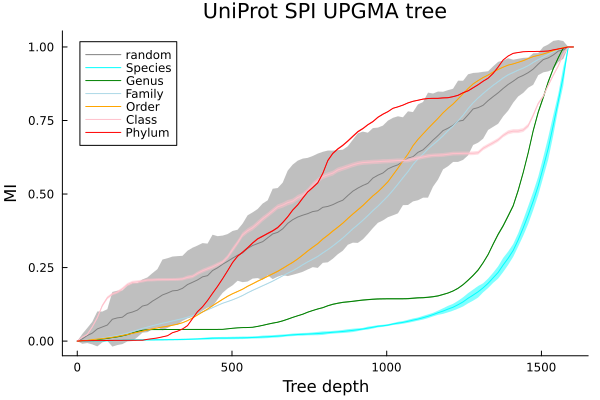

In [24]:
minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="UniProt SPI UPGMA tree", ylabel="MI", xlabel="Tree depth",
    legend=:topleft,
    grid=false
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPIupgma_pltdf)
    @df df plot!(cuts,:cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [46]:
reshape(spiMI_upgma_df.MI_boot_mean, 100, 8)

100×8 Matrix{Float64}:
 0.0  0.0         0.0          …  0.0          0.0         0.0
 0.0  1.15965e-5  3.7754e-5       1.10745e-5   7.73735e-8  2.41179e-8
 0.0  5.67403e-7  2.60582e-5      2.78499e-6   4.31877e-8  3.7473e-8
 0.0  5.15234e-6  7.35906e-5      9.93102e-6   2.85561e-8  2.89204e-8
 0.0  2.12205e-6  9.0275e-5       1.25215e-5   4.42075e-8  2.96766e-8
 0.0  2.78409e-7  0.000117008  …  1.20698e-5   3.77393e-8  3.40158e-8
 0.0  2.59697e-6  7.48668e-5      1.32203e-5   6.56319e-8  3.49486e-8
 0.0  2.48861e-6  3.63622e-5      2.12307e-5   9.80537e-8  4.0099e-8
 0.0  2.67644e-6  1.90886e-5      1.54585e-5   1.04492e-7  2.48917e-8
 0.0  1.522e-7    3.10402e-5      2.25683e-5   9.5931e-8   1.96758e-8
 ⋮                             ⋱  ⋮                        
 0.0  1.6013e-6   0.000104044     0.000511398  1.08353e-5  3.19865e-8
 0.0  6.15778e-7  0.000114901     0.000417131  1.17388e-5  4.16729e-8
 0.0  6.20741e-6  7.05615e-5      0.000336341  1.41339e-5  5.20358e-8
 0.0  1.07661e-5

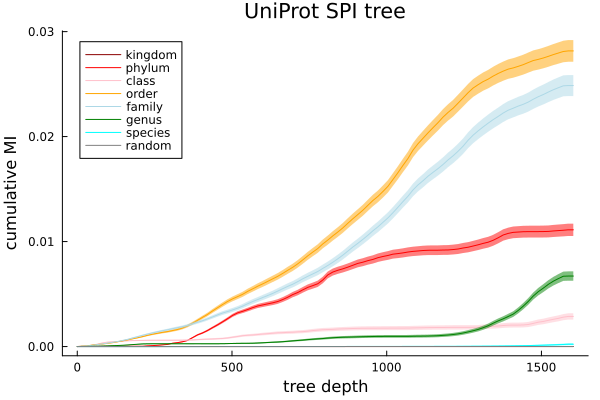

In [79]:
plot(
    cuts,
    cumsum(reshape(spiMI_upgma_df.MI_boot_mean, 100, 8), dims=1),
    ribbon=cumsum(2 * reshape(spiMI_upgma_df.MI_boot_std, 100, 8), dims=1),
    title="UniProt SPI tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [80]:
savefig(joinpath(pdir, "cumulativeMI_withbootstrapuncertainty.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UniProt_MIcurves/cumulativeMI_withbootstrapuncertainty.pdf"

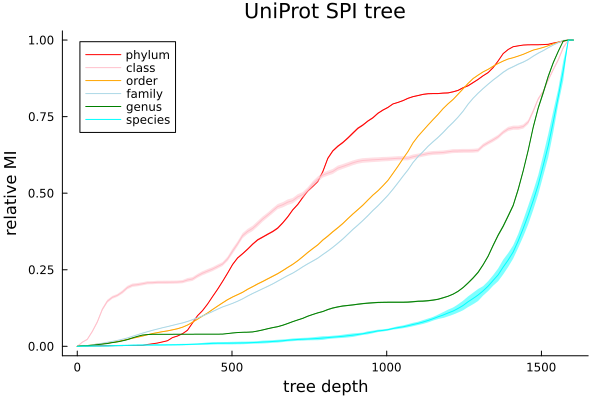

In [77]:
minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = subset(boot_SPIupgma_pltdf, :taxaID => x-> x.!="random", :taxaID => x->x.!="Kingdom")
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 6),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 6),
    title="UniProt SPI tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels[:, 2:end],
    c=taxarankcolors[:, 2:end],
    grid=false,
    legend=:topleft,
)

In [78]:
savefig(joinpath(pdir, "relativeMI_withbootstrapuncertainty.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UniProt_MIcurves/relativeMI_withbootstrapuncertainty.pdf"